In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv("modified_vin (1).csv")
df.head()

,description,variety,Red
0,Mildly pickled red-fruit aromas fail to convey...,Cabernet Sauvignon,1
1,"Smells herbaceous and weedy, with lots of gree...",Cabernet Sauvignon,1
2,"Like all of Reverie's 2007 reds, this one's su...",Cabernet Sauvignon,1
3,Straightforward plum and rubber aromas seem sl...,Cabernet Sauvignon,1
4,"Earthy notes of fresh whole tobacco leaf, lico...",Cabernet Sauvignon,1


In [ ]:
# However, in the numerical model, we decided to remove all obs where the 4 cotinuous variables were equal to 0, so we have to align our nlp dataset
n_pinot_noir = 5888
n_chardonnay = 5633
n_cabernet_sauvignon = 4405
Riesling=2820
Merlot=2209
Malbec=1263
Zinfandel=940
Sangiovese=790
# filter the DataFrame to only keep the desired number of observations for each grape variety
df_filtered = pd.concat([
    df[df['variety'] == 'Pinot Noir'].sample(n_pinot_noir, random_state=42),
    df[df['variety'] == 'Chardonnay'].sample(n_chardonnay, random_state=42),
    df[df['variety'] == 'Cabernet Sauvignon'].sample(n_cabernet_sauvignon, random_state=42),
    df[df['variety'] == 'Riesling'].sample(Riesling, random_state=42),
    df[df['variety'] == 'Merlot'].sample(Merlot, random_state=42),
    df[df['variety'] == 'Malbec'].sample(Malbec, random_state=42),
    df[df['variety'] == 'Zinfandel'].sample(Zinfandel, random_state=42),
    df[df['variety'] == 'Sangiovese'].sample(Sangiovese, random_state=42),
    
])

# reset the index of the filtered DataFrame
df = df_filtered.reset_index(drop=True)
df = df.drop('variety', axis=1)
df.head()
print(len(df))

23948


In [ ]:
# Creation of the stop list words, we added red and white
stop_words =  stopwords.words('english')
stop_append = ['.', ',', '`', '"', "'", '!', ';', 'wine', 'fruit', '%', 'flavour', 'aromas', 'palate', 'red', 'white']
stop = stop_words + stop_append

In [ ]:
df["description"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))


0        this broad-shouldered, full-bodied shows true ...
1        a bit disappointing. starts exciting blast che...
2        tons flavor pinot. dazzles waves cherries, rhu...
3        initially spicy, develops awkward barnyard cha...
4        delicious first word pops head taste wine. it'...
                               ...                        
23943    a modern brunello dark, inky concentration toa...
23944    the opens sweet bursting cherry, marzipan, cin...
23945    here's classically crafted selection, lovely f...
23946    captivating wild berry, rose, chopped herb bak...
23947    obviously shaped hot vintage, riserva delivers...
Name: description, Length: 23948, dtype: object

In [ ]:
df.head()

,description,Red
0,"This is a broad-shouldered, full-bodied wine t...",1
1,A bit disappointing. Starts off with an exciti...,1
2,Tons of flavor in this Pinot. Dazzles with wav...,1
3,"Initially spicy, this wine then develops an aw...",1
4,Delicious is the first word that pops into you...,1


In [ ]:
df = df.dropna()
df.head()

,description,Red
0,"This is a broad-shouldered, full-bodied wine t...",1
1,A bit disappointing. Starts off with an exciti...,1
2,Tons of flavor in this Pinot. Dazzles with wav...,1
3,"Initially spicy, this wine then develops an aw...",1
4,Delicious is the first word that pops into you...,1


In [ ]:
# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['Red'], test_size=0.2, random_state=42)

# Split the test data into test and validation sets (50% test, 50% validation)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
#Compute class_weights
class_weights = {}
for i in range(len(np.unique(y_train))):
    class_weights[i] = 1 / 2

print(class_weights)

{0: 0.5, 1: 0.5}


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# We tokenize our descriptions
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

In [ ]:
# We convert our datasets in a Tensor format
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(len(X_train)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(32)

In [ ]:
print(len(np.unique(y_test)))
print(len(np.unique(y_train)))

2
2


In [ ]:
# Configure the BERT model
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=len(np.unique(y_train)))
print(config)


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
# We load the pre-trained model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# We compile our model
model.compile(optimizer=Adam(learning_rate=2e-5),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [ ]:
# We tokenize the validation set
validation_encodings = tokenizer(list(X_val), truncation=True, padding=True)
validation_dataset = tf.data.Dataset.from_tensor_slices((
    dict(validation_encodings),
    y_test
)).batch(32)

In [ ]:
# We fit our pre-trained model
history = model.fit(train_dataset,
                    epochs=1,
                    validation_data=validation_dataset,
                    callbacks=[es],
                    class_weight=class_weights)

599/599 [==============================] - 697s 1s/step - loss: 0.0504 - sparse_categorical_accuracy: 0.9571 - val_loss: 2.8764 - val_sparse_categorical_accuracy: 0.5503


In [ ]:
test_labels = y_test

# Make predictions on test dataset
predictions = model.predict(test_dataset)
print(predictions)


75/75 [==============================] - 24s 276ms/step
TFSequenceClassifierOutput(loss=None, logits=array([[ 3.6389046, -3.1702013],
       [-3.1309345,  3.404157 ],
       [ 3.6277664, -3.090258 ],
       ...,
       [-3.539512 ,  3.7986708],
       [ 3.4561093, -2.9445124],
       [-3.3669653,  3.769752 ]], dtype=float32), hidden_states=None, attentions=None)


In [ ]:
from sklearn.metrics import classification_report
logits = predictions.logits
# Get the predicted labels
label_list = [0,1]
predicted_labels = tf.argmax(logits, axis=-1).numpy()
predicted_labels = [label_list[label] for label in predicted_labels]

# Print the classification report
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       821
           1       1.00      0.99      0.99      1574

    accuracy                           0.99      2395
   macro avg       0.99      0.99      0.99      2395
weighted avg       0.99      0.99      0.99      2395



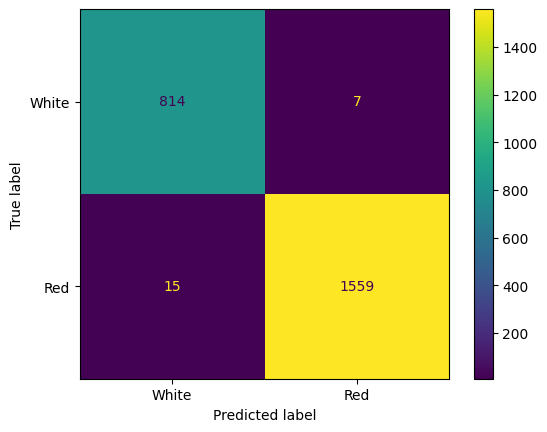

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(y_test,predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["White","Red"])

cm_display.plot()
plt.show()